## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Осипенко Анастасия Александровна

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

## Описание задания:
Вам необходимо реализовать оставшиеся методы из лекции и сравнить их на примере из семинара.

## Задание разделено на следующие части:
1. Реализация Xavier **(1 балл)**

2.1 Реализация DropConnect **(1 балл)**

2.2 Сравнение обучения при использовании Dropout и DropConnect **(1 балл)**

3.1 Реализация LayerNorm **(2 балл)**

## Срок выполнения задания:
Софт дедлайн - 8 октября 23:59  
Хард дедлайн - 15 октября 23:59


### Часть 1: Инициализация весов

Будем использовать MNIST для обучения:

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9.91M/9.91M [00:01<00:00, 8.55MB/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28.9k/28.9k [00:00<00:00, 236kB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1.65M/1.65M [00:00<00:00, 2.20MB/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4.54k/4.54k [00:00<00:00, 3.57MB/s]


In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
from pathlib import Path

# Предполагается, что YT_PREFIX и output[0].path определены ранее в коде
output_path = "ytTable:/" + str(Path("//home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/") / '2025-09-01')
output_path

'ytTable:///home/hc/predict/desc/snb/dyn_interests/v1/clickstream_tier1_daily/2025-09-01'

In [5]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    break

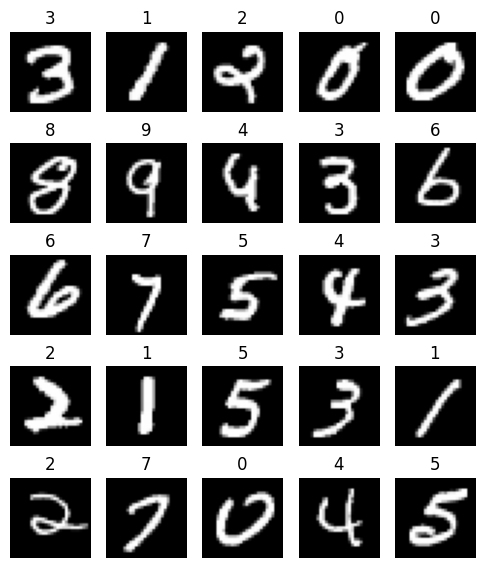

In [6]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

In [7]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

На вход передаем изображение 28x28, на выходе -- вероятности 10 классов.

In [8]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)

layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_layer(layer_1)
init_layer(layer_2)

Соберем все вместе, используя ReLU в качестве функции активации:

In [9]:
network = nn.Sequential(
    layer_1,
    nn.ReLU(),
    layer_2
)

#### 1.1 Реализуйте инициализацию Xavier. Сравните ее с He, которая была реализована на семинаре, сделайте выводы. Учтите, что для Xavier необходимо использовать функцию активации nn.Tanh(). **(1 балл)**

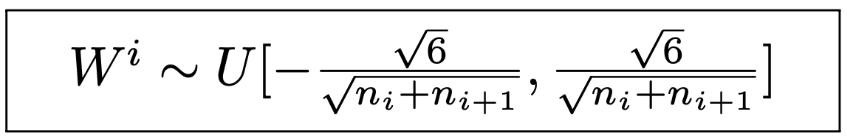

In [35]:
def init_xavier(layer):
    n_in = layer.in_features
    n_out = layer.out_features
    bound = np.sqrt(6 / (n_in + n_out))
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.uniform_(-bound, bound)

In [36]:
layer_1 = nn.Linear(28 * 28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_xavier(layer_1)
init_xavier(layer_2)

In [37]:
network_xavier = nn.Sequential(
    layer_1,
    nn.Tanh(),
    layer_2
)

In [40]:
images_train, labels_train = next(iter(train_loader))
n_objects = images_train.size(0)
X = images_train.view(n_objects, -1)
y = labels_train
activations = network_xavier(X)
loss = F.nll_loss(F.log_softmax(activations, dim=1), y)
loss.backward()

forward 0.994193434715271
forward 0.6451267600059509
backward 0.06680029630661011
backward 0.007979675196111202


In [41]:
def init_he(layer):
    n_in = layer.in_features
    std = np.sqrt(2 / n_in)
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

In [44]:
layer_1 = nn.Linear(28*28, 500)
layer_2 = nn.Linear(500, 10)

layer_1.register_forward_hook(forward_hook)
layer_2.register_forward_hook(forward_hook)
layer_1.register_backward_hook(backward_hook)
layer_2.register_backward_hook(backward_hook)

init_he(layer_1)
init_he(layer_2)

net_he = nn.Sequential(layer_1, nn.ReLU(), layer_2)
activations = net_he(X)
loss = F.nll_loss(F.log_softmax(activations, dim=1), y)
loss.backward()

forward 0.9959405064582825
forward 0.7779967784881592
backward 0.09558210521936417
backward 0.01101731974631548


## Часть 2: DropConnect

#### 2.1 Реализуйте DropConnect по следующему шаблону: **(1 балл)**

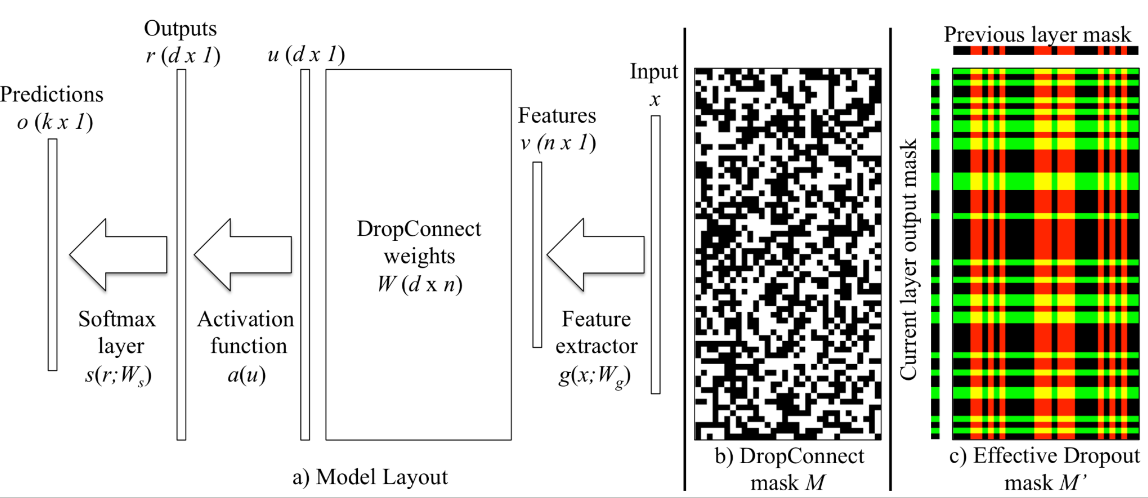

In [15]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(self.linear.weight).bernoulli_(1 - self.p)
            mask.requires_grad = False
        else:
            mask = (1 - self.p) * torch.ones_like(self.linear.weight)
            mask.requires_grad = False

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

Основа для сети, которую будем обучать:

In [18]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()

        channels = 1

        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )

        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()

        self.final_part = final_part

        self.log_softmax = nn.LogSoftmax(1)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Добавим несколько слоев в конец сети:

In [19]:
layers_dropconnect = [
    DropConnect(196, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),
    nn.ReLU(),
    nn.Linear(128, 10)
]

In [20]:
network = TestNetwork(nn.Sequential(*layers_dropconnect))
optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
loss_fn = torch.nn.NLLLoss()

Обучим получившуюся сеть:

In [21]:
for epoch in range(10):
    network.train()
    for batch_idx, (images_train, labels_train) in enumerate(train_loader):
        optimizer.zero_grad()
        X = images_train.data
        y = labels_train.data
        output = network(X)
        loss = loss_fn(output, y)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(X), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

    network.eval()
    losses = []
    for batch_idx, (images_test, labels_test) in enumerate(test_loader):
        X = images_test.data
        y = labels_test.data
        output = network(X)
        loss = loss_fn(output, y)

        losses.append(loss.item())

    print('Test Epoch: {}\tLoss: {:.6f}'.format(
            epoch, np.mean(losses)))


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.316679
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.352986
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.796690
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.490769
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.603148
Test Epoch: 0	Loss: 0.337111
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.516957
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.454095
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.327463
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.391564
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.220248
Test Epoch: 1	Loss: 0.236839
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219444
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.244184
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.353622
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.198059
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.218489
Test Epoch: 2	Loss: 0.157360
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.270839
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.296251
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.214573
Train Epoch: 3 [38400/60000 (64%)


#### 2.2 Сравните графики обучения нейроных сетей **(1 балл)**:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и DropConnect вместо всех линейных слоев


In [28]:
class Dropout(nn.Module):
    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.empty_like(x).bernoulli_(1 - self.p) / (1 - self.p)
        else:
            mask = torch.ones_like(x)
        return x * mask

layers_dropout = [
    nn.Linear(196, 128),
    nn.ReLU(),
    Dropout(p=0.5),
    nn.Linear(128, 128),
    nn.ReLU(),
    Dropout(p=0.5),
    nn.Linear(128, 10)
]

net_dropout = TestNetwork(nn.Sequential(*layers_dropout))

In [26]:
layers_dropconnect = [
    DropConnect(196, 128, p=0.5),
    nn.ReLU(),
    DropConnect(128, 128, p=0.5),
    nn.ReLU(),
    nn.Linear(128, 10)
]

net_dropconnect = TestNetwork(nn.Sequential(*layers_dropconnect))

In [22]:
def train_and_evaluate(network, name, epochs=5):
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001)
    loss_fn = torch.nn.NLLLoss()
    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        network.train()
        epoch_train_losses = []
        for batch_idx, (X, y) in enumerate(train_loader):
            optimizer.zero_grad()
            output = network(X)
            loss = loss_fn(output, y)
            loss.backward()
            optimizer.step()
            epoch_train_losses.append(loss.item())
        train_losses.append(np.mean(epoch_train_losses))

        network.eval()
        epoch_test_losses = []
        with torch.no_grad():
            for X, y in test_loader:
                output = network(X)
                loss = loss_fn(output, y)
                epoch_test_losses.append(loss.item())
        test_loss = np.mean(epoch_test_losses)
        test_losses.append(test_loss)
        print(f"[{name}] Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Test Loss = {test_loss:.4f}")

    return train_losses, test_losses

In [27]:
train_loss_do, test_loss_do = train_and_evaluate(net_dropout, "Dropout", epochs=5)
train_loss_dc, test_loss_dc = train_and_evaluate(net_dropconnect, "DropConnect", epochs=5)

[Dropout] Epoch 0: Train Loss = 0.7723, Test Loss = 0.2300
[Dropout] Epoch 1: Train Loss = 0.3459, Test Loss = 0.1704
[Dropout] Epoch 2: Train Loss = 0.2704, Test Loss = 0.1307
[Dropout] Epoch 3: Train Loss = 0.2307, Test Loss = 0.1199
[Dropout] Epoch 4: Train Loss = 0.2014, Test Loss = 0.1004
[DropConnect] Epoch 0: Train Loss = 0.8391, Test Loss = 0.2825
[DropConnect] Epoch 1: Train Loss = 0.3075, Test Loss = 0.1843
[DropConnect] Epoch 2: Train Loss = 0.2278, Test Loss = 0.1397
[DropConnect] Epoch 3: Train Loss = 0.1939, Test Loss = 0.1174
[DropConnect] Epoch 4: Train Loss = 0.1747, Test Loss = 0.1054


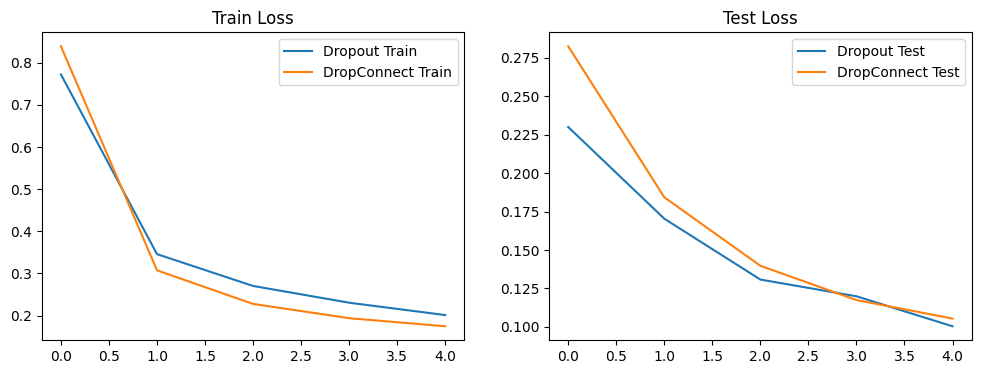

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_do, label='Dropout Train')
plt.plot(train_loss_dc, label='DropConnect Train')
plt.title('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_loss_do, label='Dropout Test')
plt.plot(test_loss_dc, label='DropConnect Test')
plt.title('Test Loss')
plt.legend()
plt.show()

### Часть 3: Layer Normalization

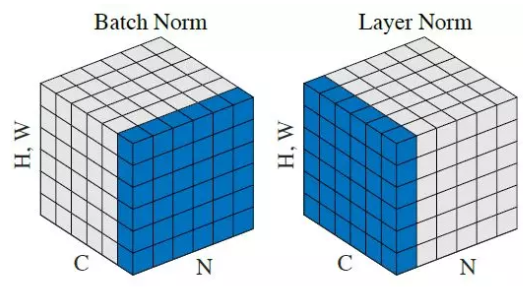

#### 3.1 Реализуйте Layer Normalization **(2 балл)**

In [30]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, eps=1e-8):
        super().__init__()
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True)
        return (x - mean) / (std + self.eps)

#### Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями

In [31]:
layers_no_ln = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]
net_no_ln = TestNetwork(nn.Sequential(*layers_no_ln))

In [32]:
layers_with_ln = [
    nn.Linear(196, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(),
    nn.ReLU(),
    nn.Linear(128, 10)
]
net_with_ln = TestNetwork(nn.Sequential(*layers_with_ln))

In [33]:
train_loss_no_ln, test_loss_no_ln = train_and_evaluate(net_no_ln, "No LayerNorm", epochs=5)
train_loss_ln, test_loss_ln = train_and_evaluate(net_with_ln, "With LayerNorm", epochs=5)

[No LayerNorm] Epoch 0: Train Loss = 0.4406, Test Loss = 0.1624
[No LayerNorm] Epoch 1: Train Loss = 0.1328, Test Loss = 0.1132
[No LayerNorm] Epoch 2: Train Loss = 0.0962, Test Loss = 0.0824
[No LayerNorm] Epoch 3: Train Loss = 0.0799, Test Loss = 0.0888
[No LayerNorm] Epoch 4: Train Loss = 0.0700, Test Loss = 0.0773
[With LayerNorm] Epoch 0: Train Loss = 0.3173, Test Loss = 0.1277
[With LayerNorm] Epoch 1: Train Loss = 0.1035, Test Loss = 0.0906
[With LayerNorm] Epoch 2: Train Loss = 0.0784, Test Loss = 0.0757
[With LayerNorm] Epoch 3: Train Loss = 0.0638, Test Loss = 0.0781
[With LayerNorm] Epoch 4: Train Loss = 0.0532, Test Loss = 0.0690


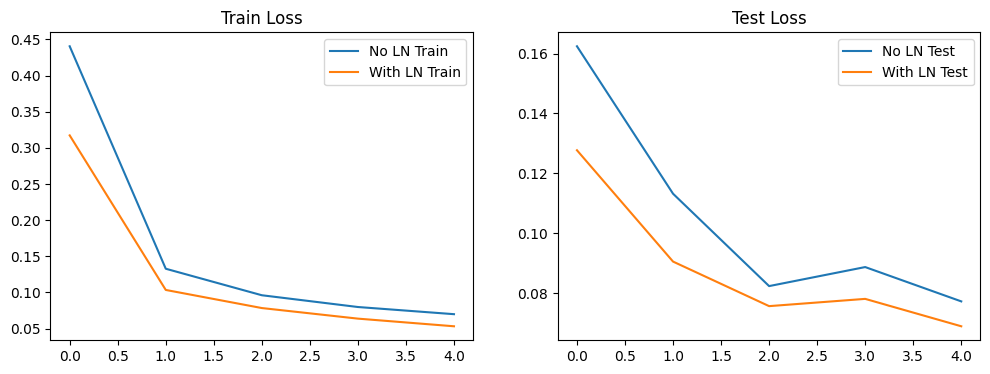

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_no_ln, label='No LN Train')
plt.plot(train_loss_ln, label='With LN Train')
plt.title('Train Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(test_loss_no_ln, label='No LN Test')
plt.plot(test_loss_ln, label='With LN Test')
plt.title('Test Loss')
plt.legend()
plt.show()